In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# !pip install pymc3
import pymc3 as pm

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special
import scipy.stats as stats
# import pymc3 as pm
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn import datasets, linear_model
# from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# Data Cleaning

In [6]:
# data1 = pd.read_csv('Data/bodyfat.csv', sep=",", header=0)
# data1 = pd.read_csv('/content/drive/My Drive/bodyfat.csv', sep=",", header=0)
data1 = pd.read_csv('/content/drive/My Drive/ColabNotebooks/bodyfat.csv', sep=",", header=0)
data1.drop(columns=data1.columns[0], axis=1, inplace=True)
data1

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


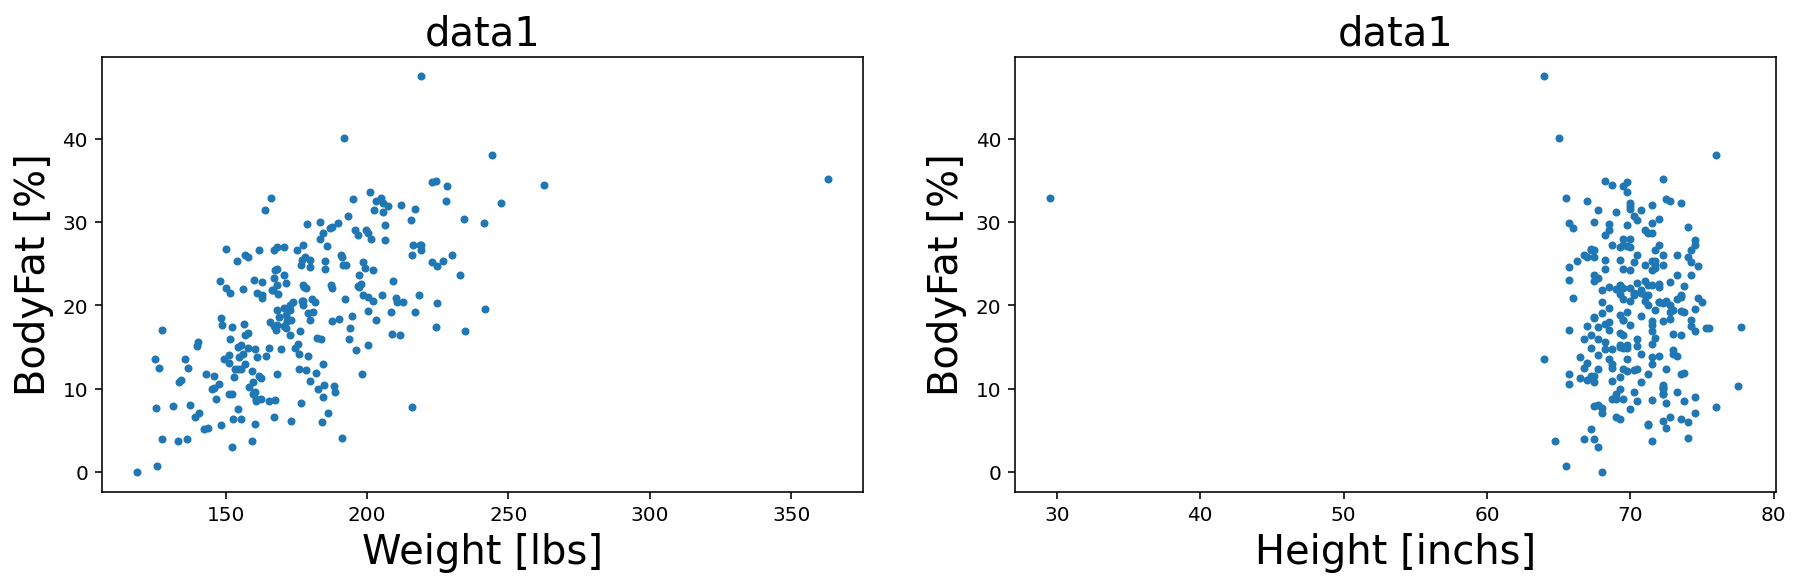

In [7]:
fig = figure(1, [15, 4])
fig.add_subplot(121)
plot(data1['Weight'], data1['BodyFat'], '.')
xlabel('Weight [lbs]', fontsize=20)
ylabel('BodyFat [%]', fontsize=20)
title('data1', fontsize=20)

fig = figure(1, [15, 4])
fig.add_subplot(122)
plot(data1['Height'], data1['BodyFat'], '.')
xlabel('Height [inchs]', fontsize=20)
ylabel('BodyFat [%]', fontsize=20)
title('data1', fontsize=20);

## Remove the outlier

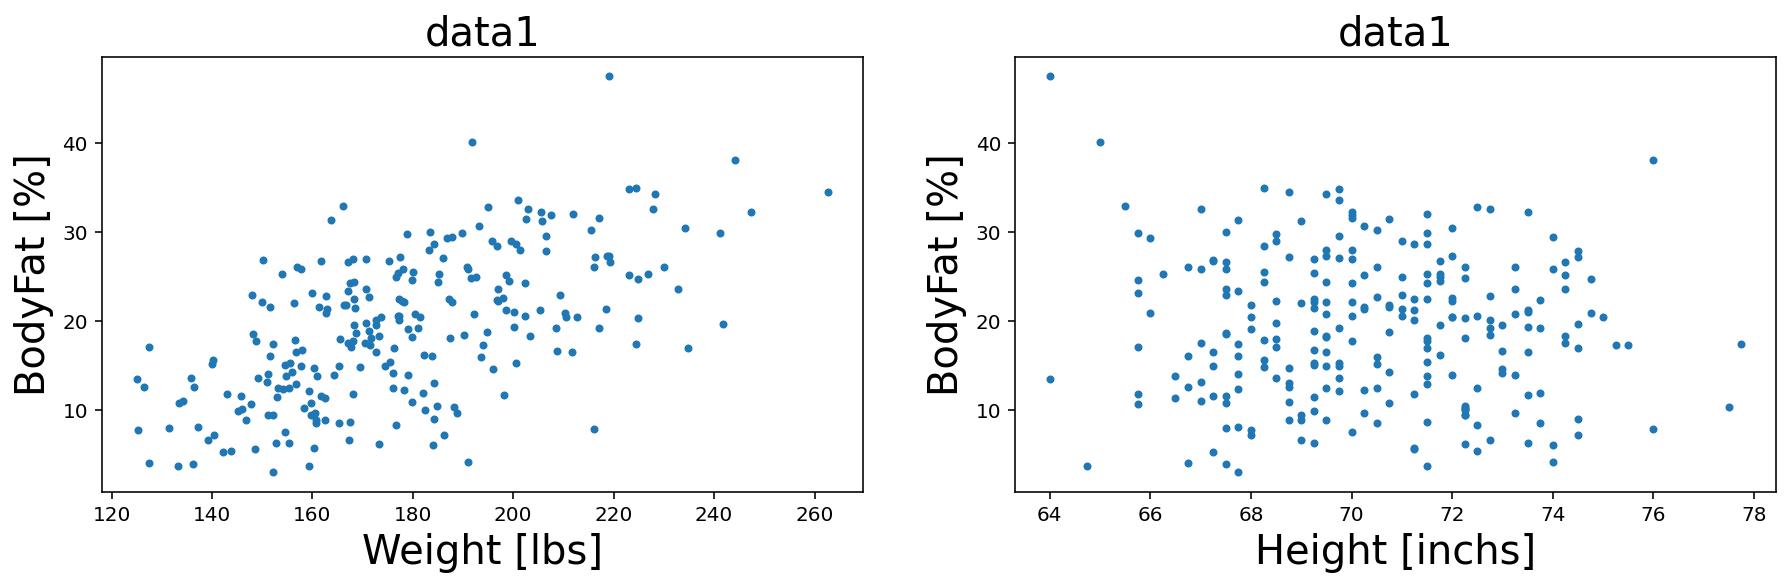

In [7]:
# remove the outlier with weight > 350 lbs, height < 30 inchs or BodyFat < 2%
outlier = data1[data1['Weight'] > 350]
data1_clean = data1.drop(outlier.index)
outlier = data1_clean[data1_clean['Height'] <30]
data1_clean = data1_clean.drop(outlier.index)
outlier = data1[data1['BodyFat'] < 2]
data1_clean = data1_clean.drop(outlier.index)
data1 = data1_clean.copy()
fig = figure(1, [15, 4])
fig.add_subplot(121)
plot(data1['Weight'], data1['BodyFat'], '.')
xlabel('Weight [lbs]', fontsize=20)
ylabel('BodyFat [%]', fontsize=20)
title('data1', fontsize=20)

fig = figure(1, [15, 4])
fig.add_subplot(122)
plot(data1['Height'], data1['BodyFat'], '.')
xlabel('Height [inchs]', fontsize=20)
ylabel('BodyFat [%]', fontsize=20)
title('data1', fontsize=20);

## Add a new variable: BMI=weight/height^2

In [8]:
# transfer weight from lbs to kg
weight = data1['Weight']*454/1000
# transfer height from inch to m
height = data1['Height']*2.54/100
data1['BMI'] = weight/((height)**2)
data1

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.648031
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.355327
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.690926
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.905609
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.540311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,11.0,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,21.045202
248,33.6,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,29.073415
249,29.3,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,30.169017
250,26.0,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,27.006900


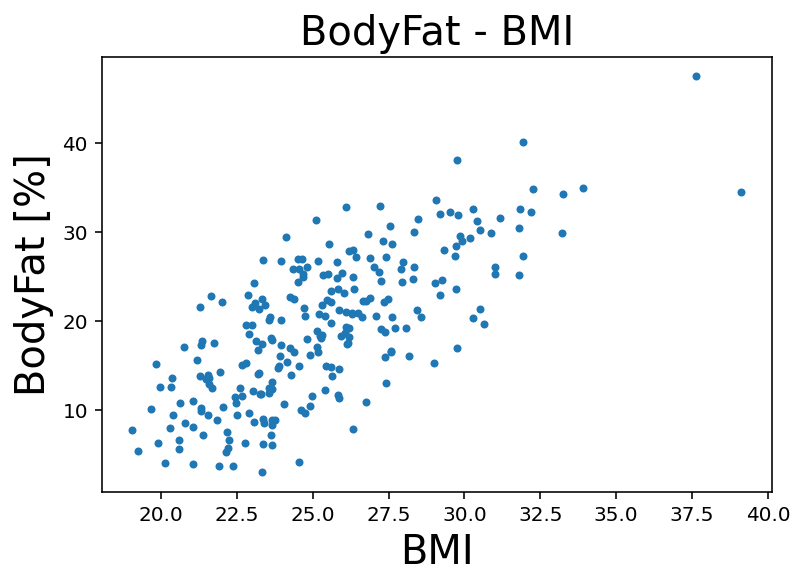

In [10]:
plot(data1['BMI'], data1['BodyFat'], '.')
xlabel('BMI', fontsize=20)
ylabel('BodyFat [%]', fontsize=20)
title('BodyFat - BMI', fontsize=20);

# Check assumptions

## BodyFat vs. other variables

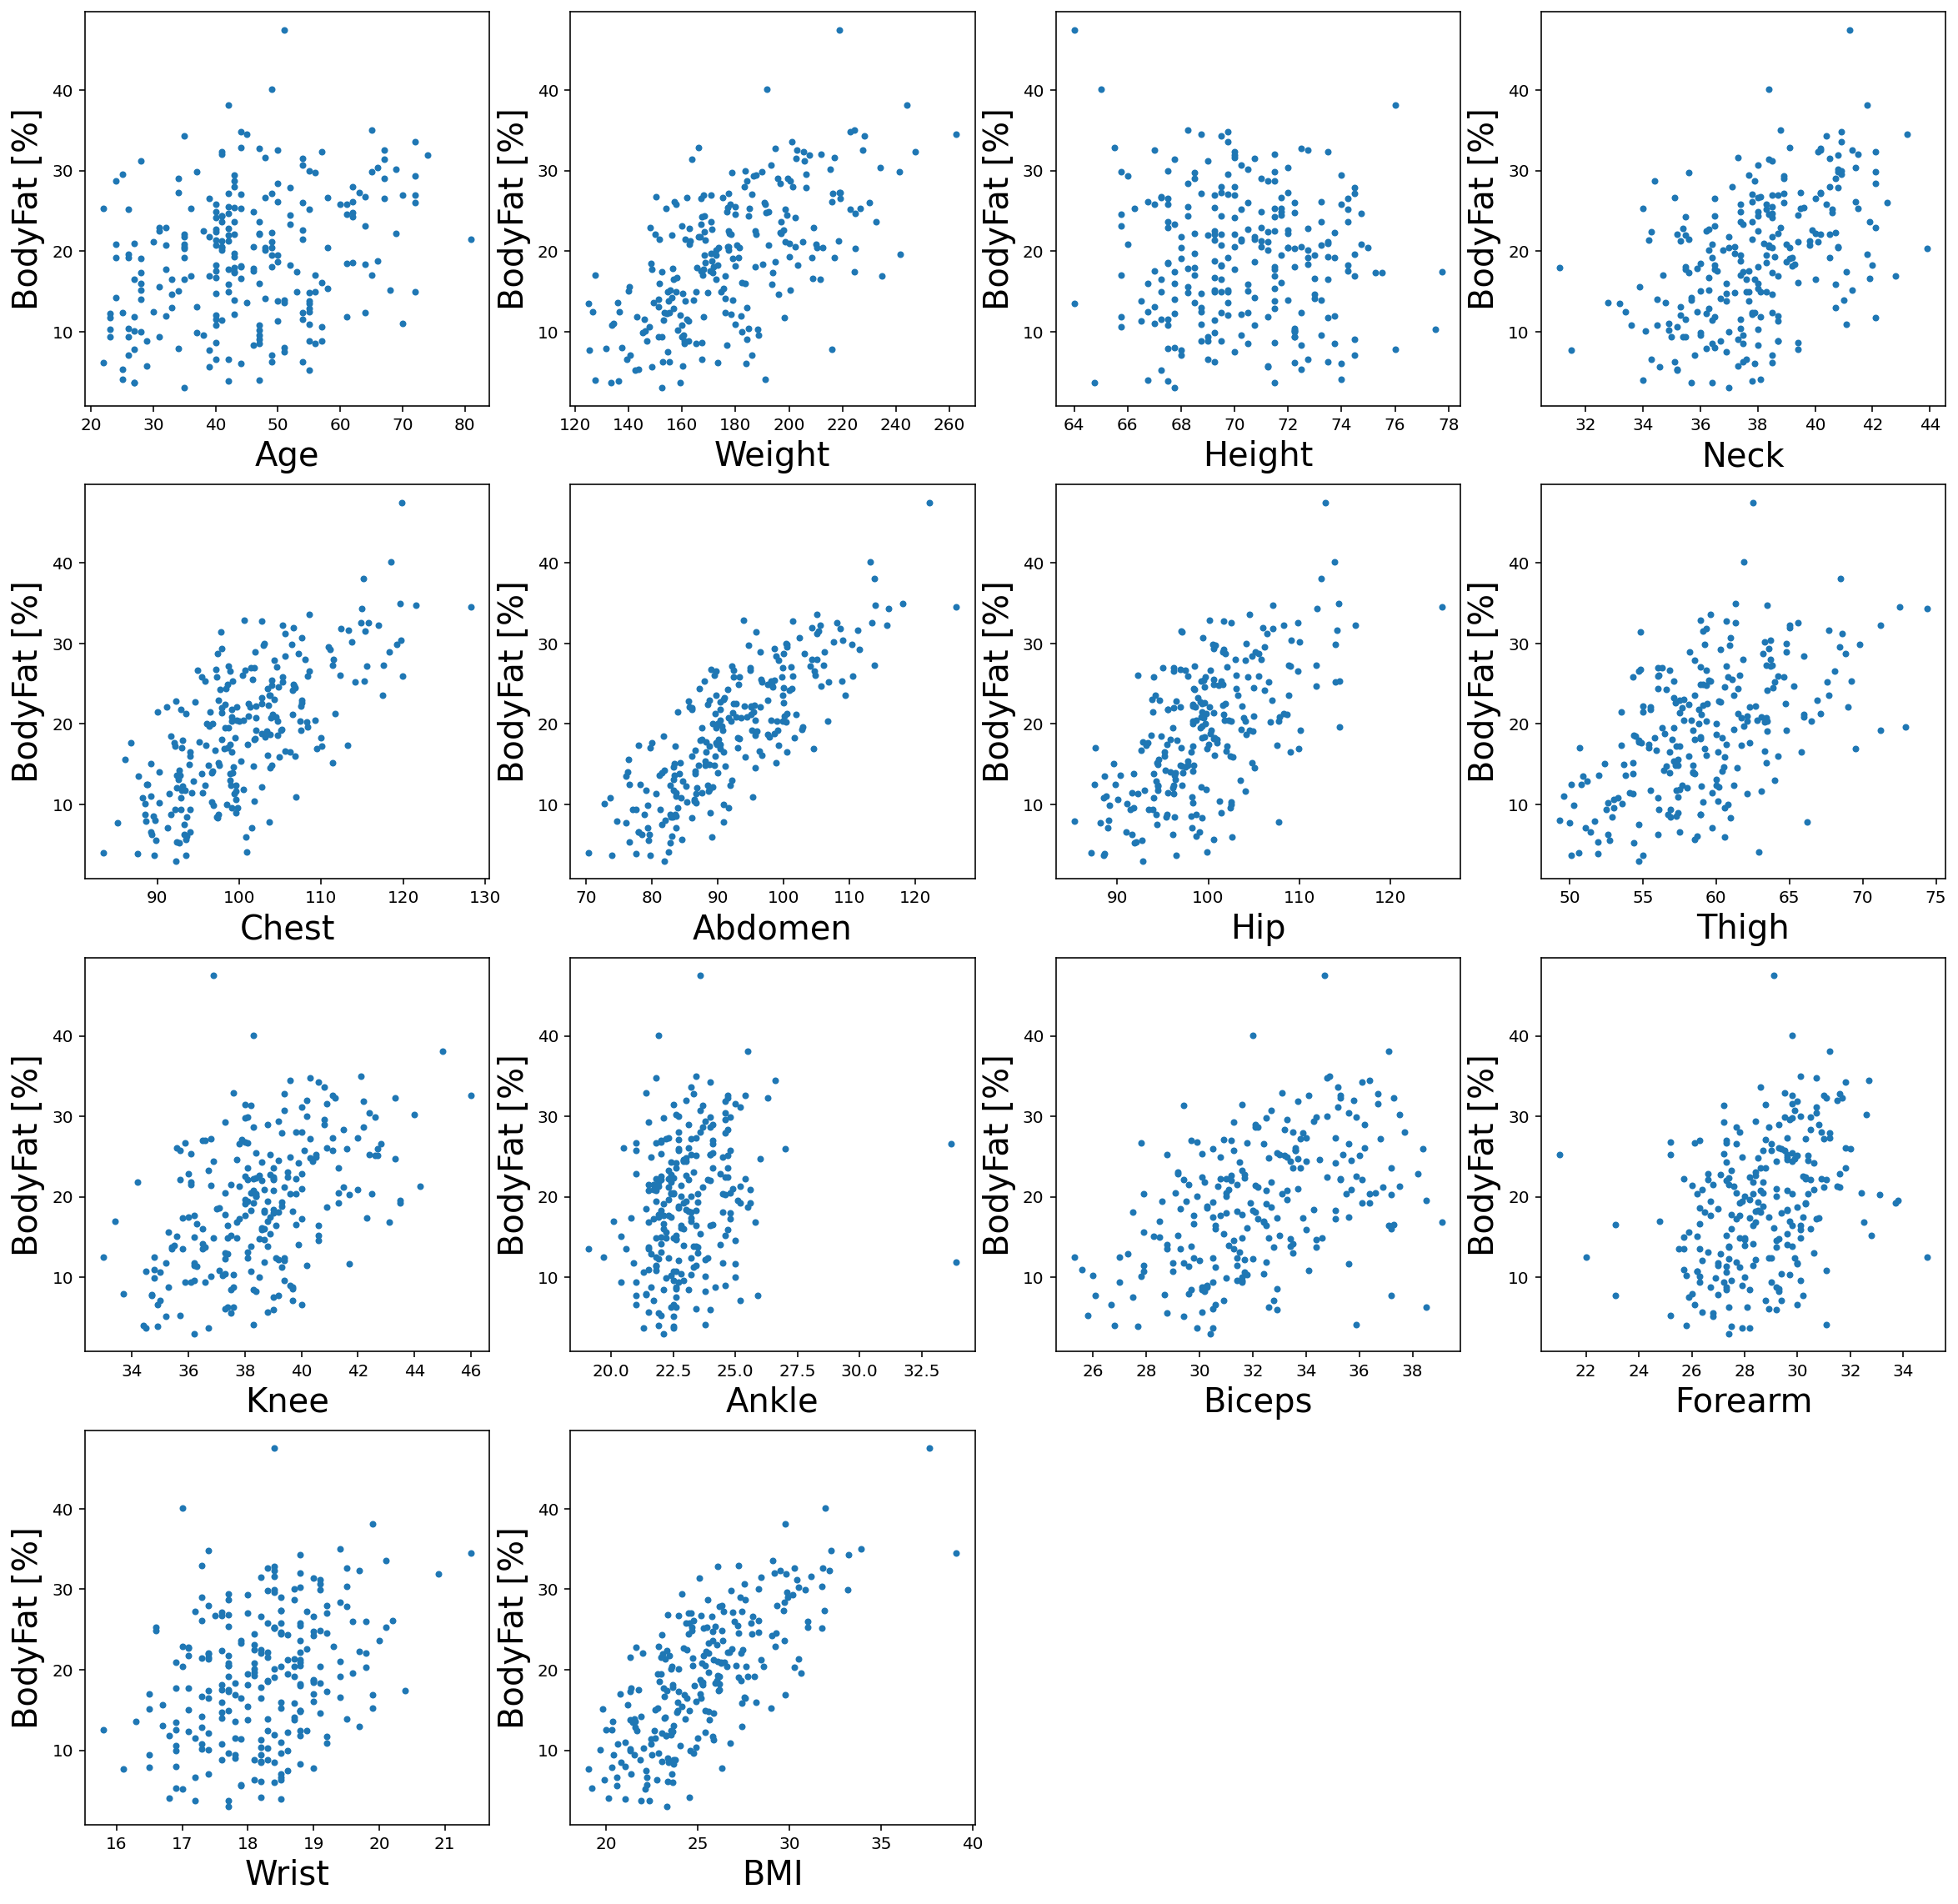

In [11]:
fig = figure(1, [20, 20]) 
total_columns = data1.columns.copy().drop('BodyFat')
for i in range(len(total_columns)): 
    fig.add_subplot(4,4,i+1) 
    plot(data1[total_columns[i]], data1['BodyFat'], '.')
    xlabel(total_columns[i], fontsize=20)
    ylabel('BodyFat [%]', fontsize=20)

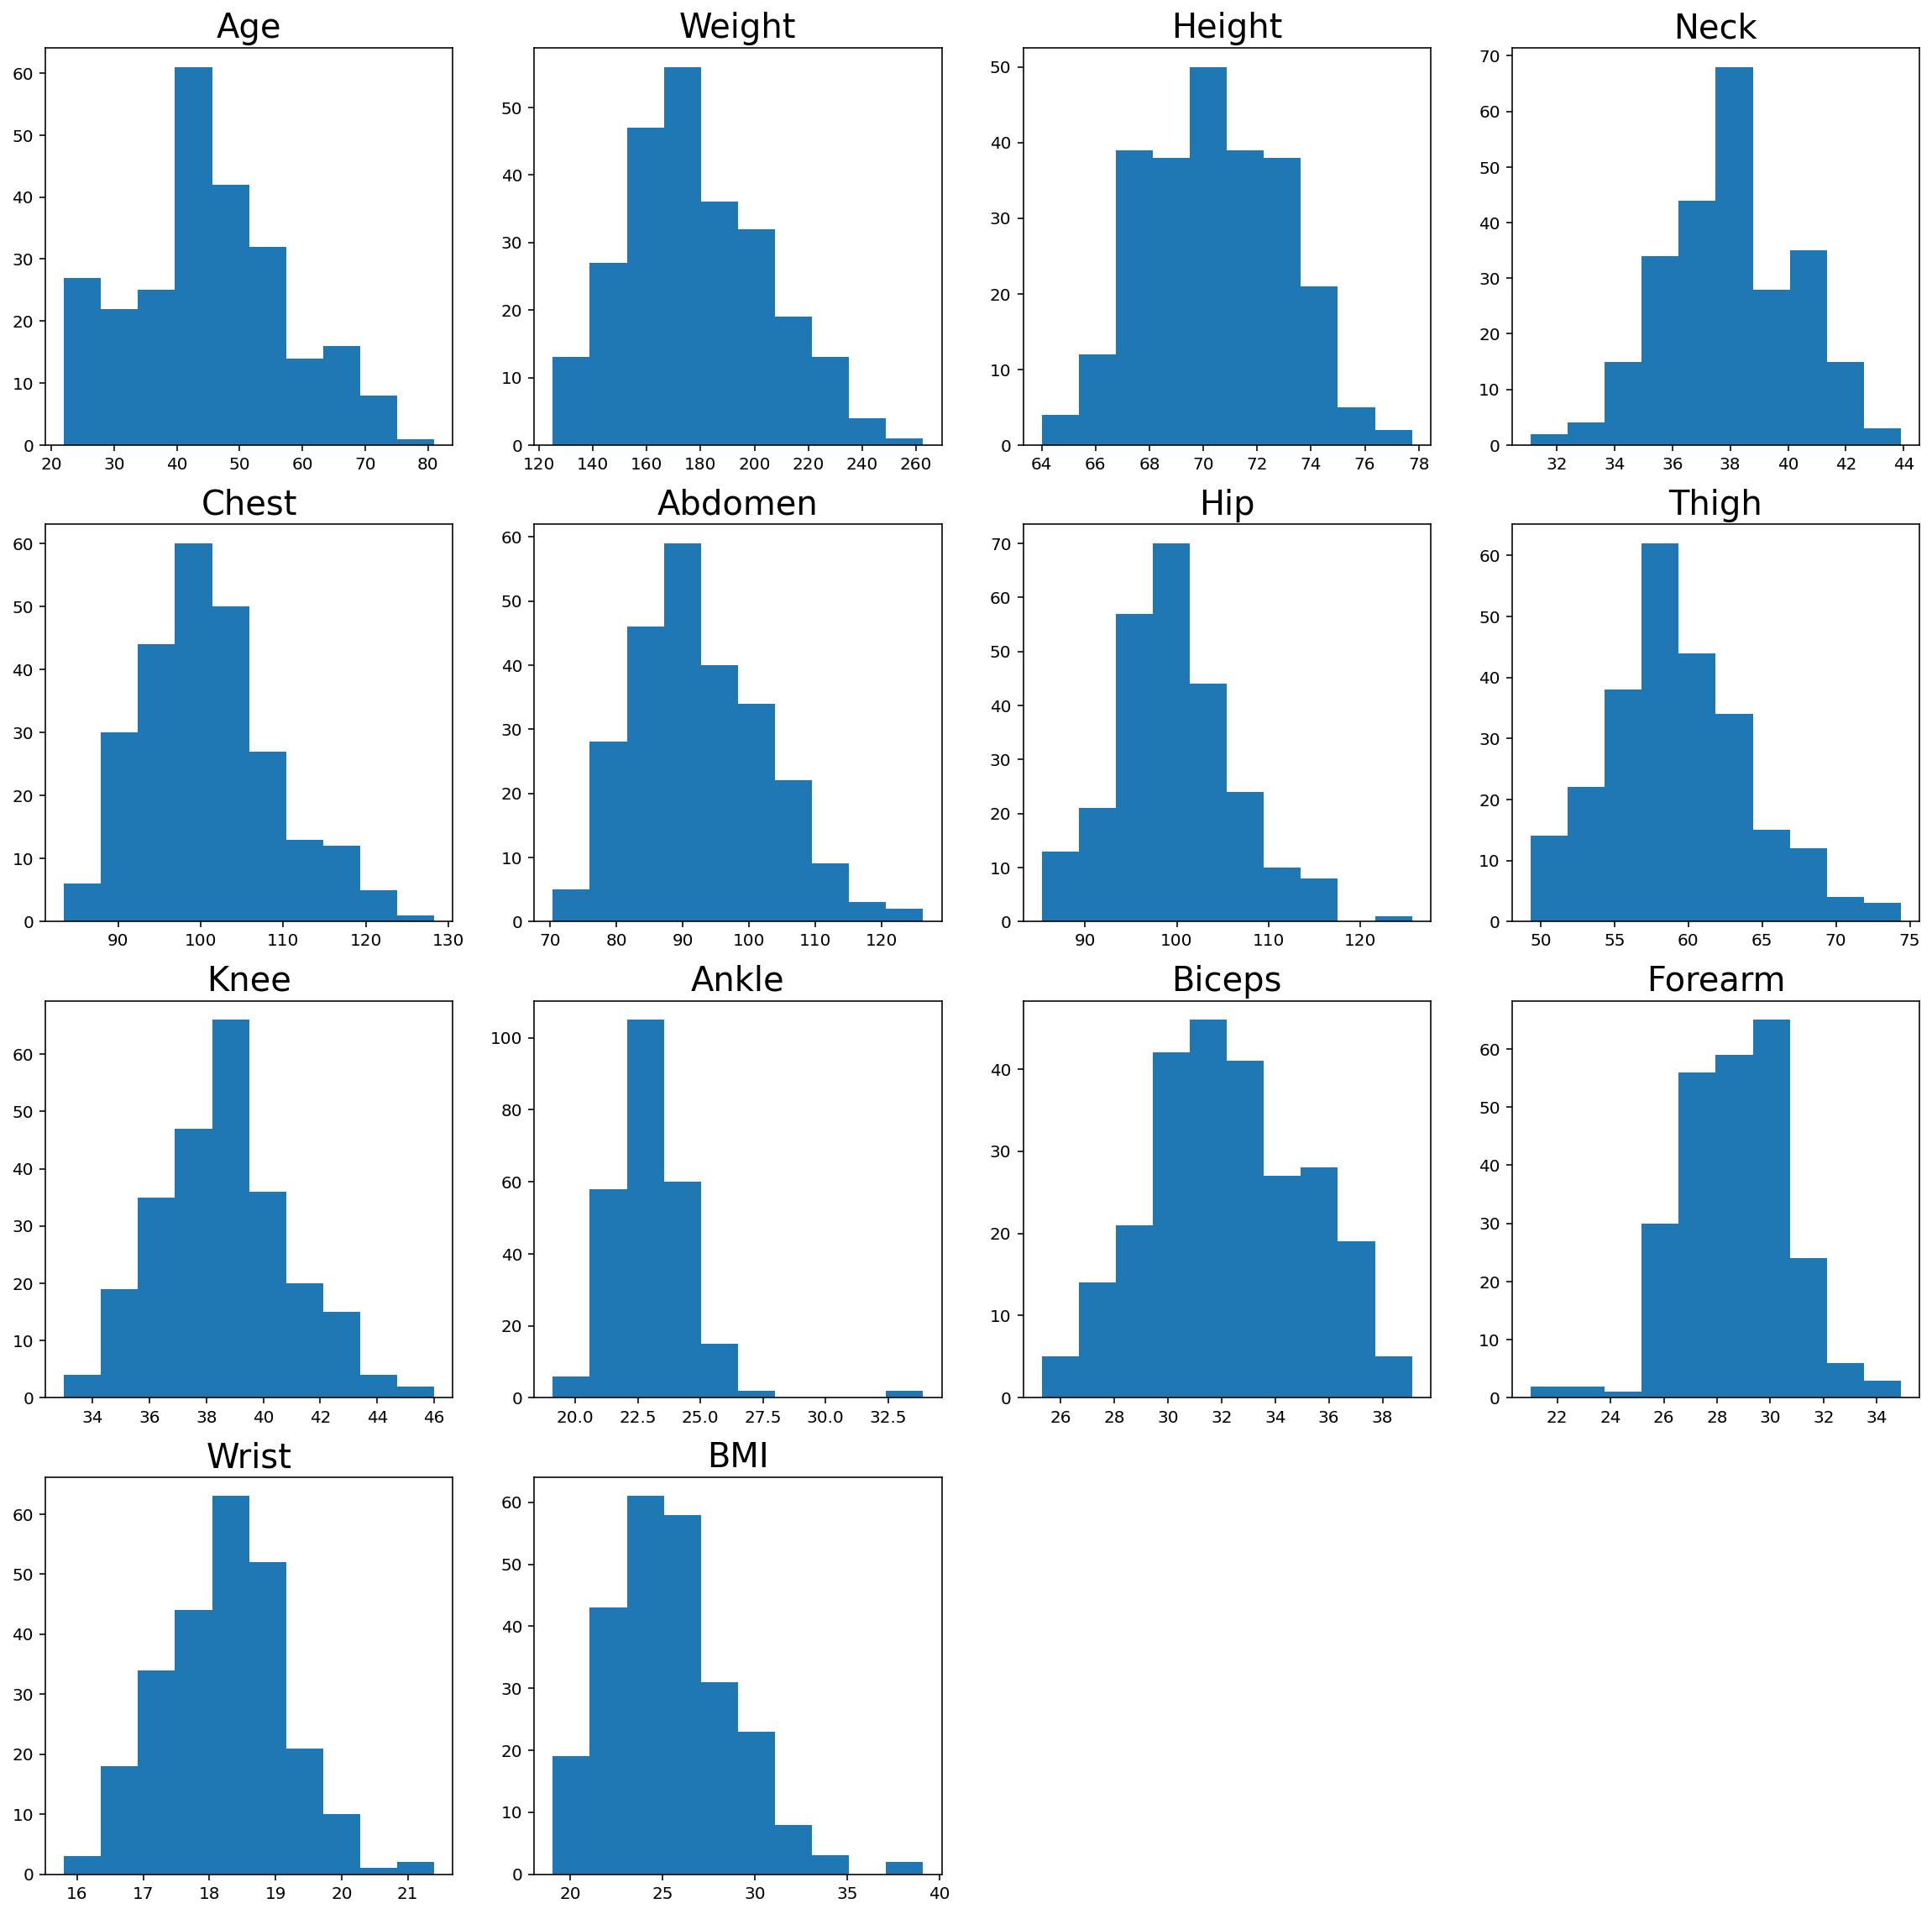

In [12]:
# the distribution of predictor variables
# the distribution for bmi a little right skewed.
fig = figure(1, [20, 20]) 
total_columns = data1.columns.copy().drop('BodyFat')
for i in range(len(total_columns)): 
    fig.add_subplot(4,4,i+1) 
    plt.hist(data1[total_columns[i]])
    title(total_columns[i], fontsize=20)

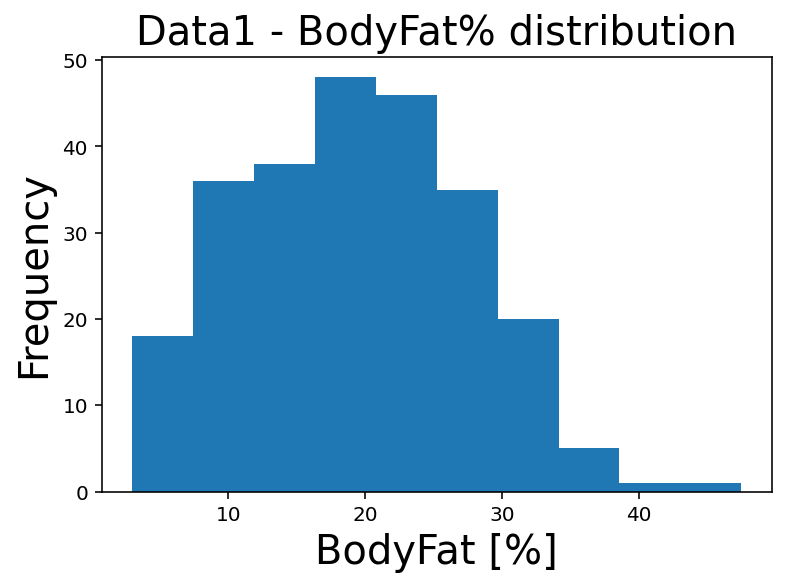

In [13]:
#the distribution of reponse variable: normal distribution 
plt.hist(data1["BodyFat"])
title('Data1 - BodyFat% distribution', fontsize=20);
xlabel('BodyFat [%]', fontsize=20)
ylabel('Frequency', fontsize=20);

In [14]:
def get_prior_predictive(total_columns, query_var, train_x):
    # other variables do not change
    # steady_vars = list(train_x.columns)
    steady_vars = total_columns.copy()
    steady_vars.remove(query_var)
    xmin = train_x[query_var].min() 
    xmax = train_x[query_var].max() 
    x = linspace(xmin, xmax, 20) 
    bodyfat_avg = alpha[None, :] + beta[query_var][None, :]*x[:, None]
    
    # Each non-query variable is assumed to be at the mean value
    for var in steady_vars:
        xmin = train_x[var].min() 
        xmax = train_x[var].max() 
        steady_x = linspace(xmin, xmax, 20) 
        bodyfat_avg += beta[var] * steady_x.mean()
    
    plot(x, bodyfat_avg, '0.5', lw=0.5) 
    title('prior predictive simulation for ' + query_var) 
    xlabel(query_var, fontsize=20) 
    ylabel('body fat', fontsize=20);

# Divide train and test dataset

In [9]:
def split(x_full):
    """
    use Random permutation cross-validator "ShuffleSplit" to repeatedly randomly
    partitioning the available data into training and test sets
    """
    # split dataset into training/testing set, 80% for training, 20% for testing.
    ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=2)
    # split_index = []
    for train_index, test_index in ss.split(x_full):
        return [train_index, test_index]
        # split_index.append()
    # return split_index

In [10]:
# divide train and test dataset
train_index = split(data1)[0]
test_index = split(data1)[1]
data1_train = data1.iloc[train_index]
data1_test = data1.iloc[test_index]

# divide X and Y
# data1_train_x, data1_train_y = datasets.load
data1_train_y = data1_train.iloc[:, 0]
data1_train_x = data1_train.iloc[:, 1:]
data1_test_y = data1_test.iloc[:, 0]
data1_test_x = data1_test.iloc[:, 1:]

In [11]:
data1_train_x

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
130,49,171.75,71.50,35.5,97.8,90.1,95.8,57.0,38.7,23.2,27.5,26.5,17.6,23.641394
149,26,223.00,70.25,40.6,114.1,106.8,113.9,67.6,42.7,24.7,36.0,30.4,18.4,31.798060
56,58,181.50,68.00,39.1,100.0,99.8,102.5,62.1,39.6,22.5,33.1,28.3,18.5,27.621498
122,40,160.25,68.75,36.9,99.3,83.3,97.5,60.5,38.7,22.6,34.4,28.0,17.6,23.858386
101,48,173.75,72.00,37.0,99.1,92.0,98.3,59.3,38.4,22.4,27.9,26.2,17.0,23.585671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,31,140.25,68.25,33.9,86.0,76.4,94.6,57.4,35.3,22.2,27.9,25.9,16.7,21.187806
74,61,143.00,65.75,36.5,93.4,83.3,93.0,55.5,35.2,20.9,29.4,27.0,16.8,23.277318
241,65,224.50,68.25,38.8,119.6,118.0,114.3,61.3,42.1,23.4,34.9,30.1,19.4,33.915596
15,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,26.291874


# Model using different methods

## Model 1: Simple linear regression model with BMI

\begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{bmi}BMI_{i} \\
    \alpha &\sim \text{Normal}(25, 10) \\
    \beta_{bmi} &\sim \text{Normal}(0, 0.02) \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

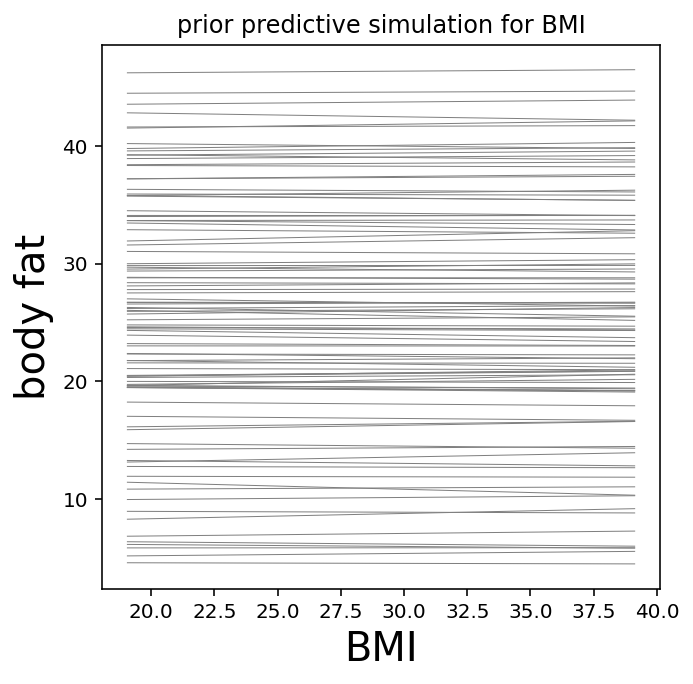

In [21]:
# check prior
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(25, 10, size=n_samples)
beta = pd.DataFrame() 
beta['BMI'] = stats.norm.rvs(0, 0.02, size=n_samples)
 
fig = figure(1, [5, 5]) 
total_columns = ['BMI']
get_prior_predictive(total_columns, 'BMI', data1_train_x)

In [12]:
with pm.Model() as model_1:
    sigma = pm.Exponential('sigma', 1)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=0.02)
    alpha = pm.Normal('alpha', mu=25, sd=10)
    _mu = alpha + beta_bmi*data1_train_x['BMI']
    mu = pm.Deterministic('mu', _mu)
    F = pm.Normal('BodyFat', mu=mu, sd=sigma, observed=data1_train_y)
    _model_1_mcmc_samples = pm.sample(1000, tune=1000)
    print(pm.summary(_model_1_mcmc_samples, var_names=['sigma','beta_bmi','alpha' ]))
model_1_mcmc_samples = pm.trace_to_dataframe(_model_1_mcmc_samples)
# model_1_mcmc_samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_bmi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


            mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
sigma      7.989  0.394   7.251    8.723  ...    0.007    1502.0    1479.0    1.0
beta_bmi   0.024  0.020  -0.014    0.063  ...    0.000    1019.0    1237.0    1.0
alpha     18.845  0.772  17.392   20.241  ...    0.017    1033.0    1338.0    1.0

[3 rows x 9 columns]


## Model 2: Multiple regression model
\begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{bmi}BMI_{i} + \beta_{c}Chest_{i} +  \beta_{h}Hip_{i} + \beta_{a}Abdomen_{i}\\
    \alpha &\sim \text{Normal}(25, 10) \\
    \beta_{bmi} &\sim \text{Normal}(0, 0.02) \\
    \beta_{c} &\sim \text{Normal}(0, 0.02) \\
    \beta_{h} &\sim \text{Normal}(0, 0.02) \\
    \beta_{a} &\sim \text{Normal}(0, 0.02) \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

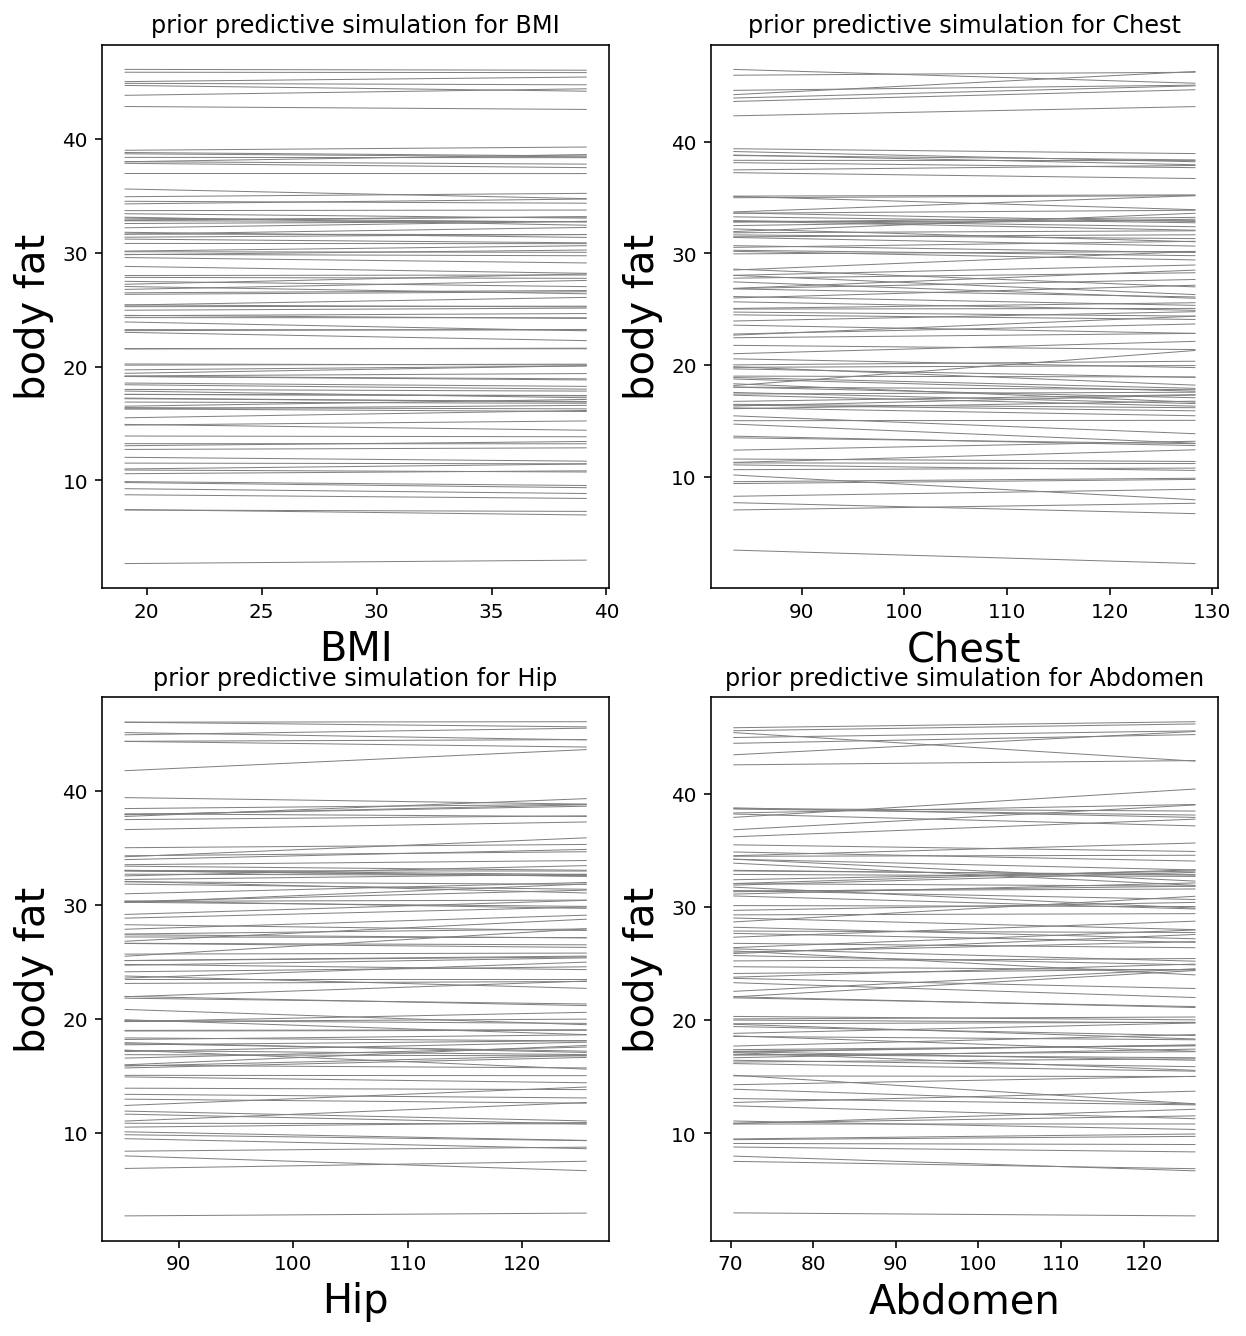

In [34]:
# check prior
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(25, 10, size=n_samples)
beta = pd.DataFrame() 
beta['BMI'] = stats.norm.rvs(0, 0.02, size=n_samples) 
beta['Chest'] = stats.norm.rvs(0, 0.02, size=n_samples)  
beta['Abdomen'] = stats.norm.rvs(0, 0.02, size=n_samples)  
beta['Hip'] = stats.norm.rvs(0, 0.02, size=n_samples)    
 
fig = figure(1, [10, 11]) 
total_columns = ['BMI','Chest','Hip','Abdomen']
for i in range(len(total_columns)): 
    fig.add_subplot(2,2,i+1) 
    get_prior_predictive(total_columns, total_columns[i], data1_train_x)

In [13]:
with pm.Model() as model_2:
    sigma = pm.Exponential('sigma', 1)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=0.02)
    beta_c = pm.Normal('beta_c', mu=0, sd=0.02)
    beta_h = pm.Normal('beta_h', mu=0, sd=0.02)
    beta_a = pm.Normal('beta_a', mu=0, sd=0.02)
    alpha = pm.Normal('alpha', mu=25, sd=10)
    _mu = alpha + beta_bmi*data1_train_x['BMI'] + beta_c*data1_train_x['Chest'] + beta_h*data1_train_x['Hip'] + beta_a*data1_train_x['Abdomen']
    mu = pm.Deterministic('mu', _mu)
    F = pm.Normal('BodyFat', mu=mu, sd=sigma, observed=data1_train_y)
    _model_2_mcmc_samples = pm.sample(1000, tune=1000)
    print(pm.summary(_model_2_mcmc_samples, var_names=['sigma','beta_bmi','beta_c','beta_h','beta_a','alpha' ]))
model_2_mcmc_samples = pm.trace_to_dataframe(_model_2_mcmc_samples)
# model_2_mcmc_samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_a, beta_h, beta_c, beta_bmi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


           mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
sigma     7.117  0.405   6.355    7.844  ...    0.008    1142.0    1289.0    1.0
beta_bmi  0.022  0.020  -0.013    0.061  ...    0.000    1617.0    1331.0    1.0
beta_c    0.047  0.020   0.009    0.083  ...    0.000    1302.0    1312.0    1.0
beta_h    0.029  0.020  -0.008    0.067  ...    0.000    1316.0    1262.0    1.0
beta_a    0.075  0.020   0.033    0.109  ...    0.000    1153.0    1255.0    1.0
alpha     4.293  3.290  -2.134    9.987  ...    0.074    1001.0    1083.0    1.0

[6 rows x 9 columns]


## Model 3: Adjusted multiple regression model according to correlation table


In [36]:
# correlation between each variables.
# correlation>0.7 indicates strong linear relationship.
cor = data1.corr()
cor[cor>0.7]

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
BodyFat,1.000000,NaN,NaN,NaN,NaN,NaN,0.817574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.737221
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,NaN,NaN,1.000000,NaN,0.804558,0.888887,0.869499,0.930595,0.846608,0.837725,NaN,0.779015,NaN,0.717681,0.863200
Height,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neck,NaN,NaN,0.804558,NaN,1.000000,0.763701,0.720884,NaN,NaN,NaN,NaN,0.700891,NaN,0.724737,0.746337
Chest,NaN,NaN,0.888887,NaN,0.763701,1.000000,0.907800,0.819605,NaN,NaN,NaN,0.702425,NaN,NaN,0.908917
Abdomen,0.817574,NaN,0.869499,NaN,0.720884,0.907800,1.000000,0.855953,0.727548,0.701240,NaN,NaN,NaN,NaN,0.911496
Hip,NaN,NaN,0.930595,NaN,NaN,0.819605,0.855953,1.000000,0.877016,0.803146,NaN,0.714803,NaN,NaN,0.856887
Thigh,NaN,NaN,0.846608,NaN,NaN,NaN,0.727548,0.877016,1.000000,0.769919,NaN,0.736733,NaN,NaN,0.780177
Knee,NaN,NaN,0.837725,NaN,NaN,NaN,0.701240,0.803146,0.769919,1.000000,NaN,NaN,NaN,NaN,NaN


 \begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{bmi}BMI_{i} + \beta_{ag}Age_{i} + \beta_{h}Height_{i} + \beta_{a}Abdomen_{i} +\beta_{f}Forearm_{i} + \beta_{an}Ankle_{i}\\
    \alpha &\sim \text{Normal}(25, 10) \\
    \beta_{bmi} &\sim \text{Normal}(0, 0.02) \\
    \beta_{ag} &\sim \text{Normal}(0, 0.02) \\
    \beta_{h} &\sim \text{Normal}(0, 0.02) \\
    \beta_{a} &\sim \text{Normal}(0, 0.02) \\
    \beta_{f} &\sim \text{Normal}(0, 0.02) \\
    \beta_{an} &\sim \text{Normal}(0, 0.02) \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

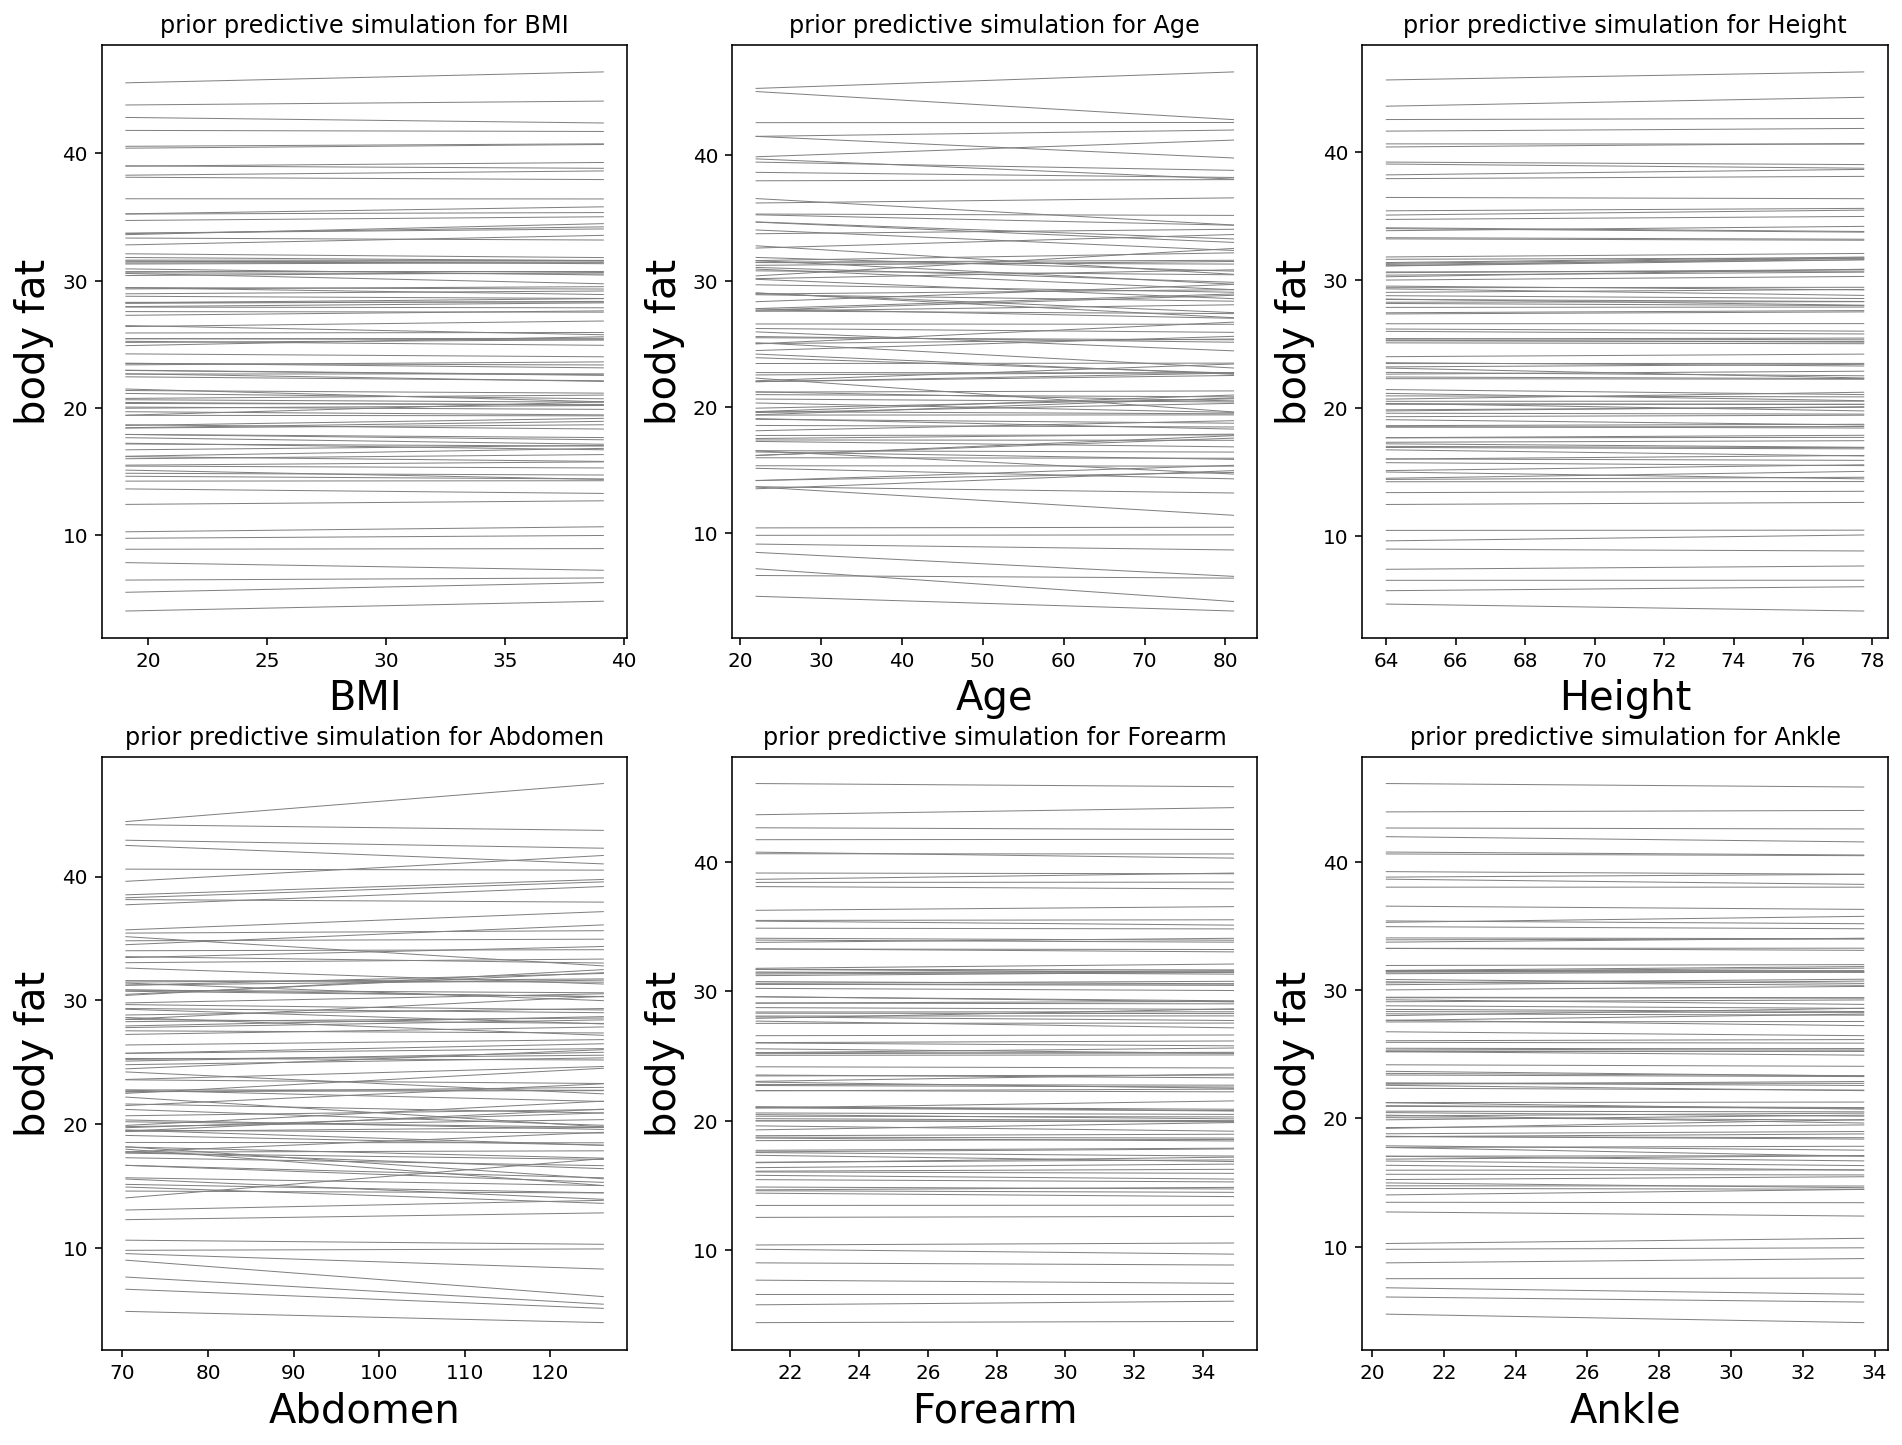

In [ ]:
# check prior
n_samples = 100  # 100 lines
alpha = stats.norm.rvs(25, 10, size=n_samples)
beta = pd.DataFrame() 
beta['BMI'] = stats.norm.rvs(0, 0.02, size=n_samples) 
beta['Age'] = stats.norm.rvs(0, 0.02, size=n_samples)
beta['Height'] = stats.norm.rvs(0, 0.02, size=n_samples)  
beta['Abdomen'] = stats.norm.rvs(0, 0.02, size=n_samples)  
beta['Forearm'] = stats.norm.rvs(0, 0.02, size=n_samples) 
beta['Ankle'] = stats.norm.rvs(0, 0.02, size=n_samples)
 
fig = figure(1, [16, 12]) 
total_columns = ['BMI','Age','Height','Abdomen','Forearm','Ankle']
for i in range(len(total_columns)): 
    fig.add_subplot(2,3,i+1) 
    get_prior_predictive(total_columns, total_columns[i], data1_train_x)

In [14]:
with pm.Model() as model_3:
    sigma = pm.Exponential('sigma', 1)
    beta_bmi = pm.Normal('beta_bmi', mu=0, sd=0.02)
    beta_ag = pm.Normal('beta_ag', mu=0, sd=0.02)
    beta_h = pm.Normal('beta_h', mu=0, sd=0.02)
    beta_a = pm.Normal('beta_a', mu=0, sd=0.02)
    beta_f = pm.Normal('beta_f', mu=0, sd=0.02)
    beta_an = pm.Normal('beta_an', mu=0, sd=0.02)
    alpha = pm.Normal('alpha', mu=25, sd=10)
    _mu = alpha + beta_bmi*data1_train_x['BMI']+beta_ag*data1_train_x['Age'] + beta_h*data1_train_x['Height'] + beta_a*data1_train_x['Abdomen']+ beta_f*data1_train_x['Forearm']+ beta_an*data1_train_x['Ankle']
    mu = pm.Deterministic('mu', _mu)
    F = pm.Normal('BodyFat', mu=mu, sd=sigma, observed=data1_train_y)
    _model_3_mcmc_samples = pm.sample(1000, tune=1000)
    print(pm.summary(_model_3_mcmc_samples, var_names=['sigma','beta_bmi','beta_ag','beta_h','beta_a','beta_f','beta_an','alpha' ]))
model_3_mcmc_samples = pm.trace_to_dataframe(_model_3_mcmc_samples)
# model_3_mcmc_samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_an, beta_f, beta_a, beta_h, beta_ag, beta_bmi, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


            mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
sigma      7.273  0.393   6.563    8.003  ...    0.007    1381.0    1334.0    1.0
beta_bmi   0.025  0.020  -0.012    0.065  ...    0.000    2261.0    1527.0    1.0
beta_ag    0.034  0.019  -0.001    0.071  ...    0.000    2060.0    1282.0    1.0
beta_h    -0.007  0.020  -0.044    0.030  ...    0.000    1774.0    1376.0    1.0
beta_a     0.080  0.019   0.037    0.111  ...    0.000    1201.0    1147.0    1.0
beta_f     0.005  0.020  -0.032    0.043  ...    0.000    2606.0    1351.0    1.0
beta_an    0.003  0.020  -0.035    0.039  ...    0.000    2239.0    1428.0    1.0
alpha     10.207  2.587   5.570   15.299  ...    0.058     991.0    1156.0    1.0

[8 rows x 9 columns]


## Model 4: model using backward stepwise selection

In [15]:
# backward stepwise selection
x_columns = ["Age","Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle","Biceps","Forearm", "Wrist","BMI"]
y = data1_train_y
def get_stats():
    x = data1_train_x[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
    return results.params
# get_stats()
x_columns.remove("Knee")
# get_stats()
x_columns.remove("BMI")
# get_stats()
x_columns.remove("Chest")
# get_stats()
x_columns.remove("Thigh")
# get_stats()
x_columns.remove("Hip")
# get_stats()
x_columns.remove("Forearm")
# get_stats()
x_columns.remove("Neck")
# get_stats()
x_columns.remove("Weight")
# get_stats()
x_columns.remove("Biceps")
# get_stats()
x_columns.remove("Ankle")
backwards_params = get_stats()

                                 OLS Regression Results                                
Dep. Variable:                BodyFat   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1098.
Date:                Thu, 09 Dec 2021   Prob (F-statistic):                   5.24e-132
Time:                        04:45:27   Log-Likelihood:                         -571.38
No. Observations:                 198   AIC:                                      1151.
Df Residuals:                     194   BIC:                                      1164.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

 **backward stepwise selection result model**
 \begin{align*}
    F_{i} = 0.0603*Age_{i} - 0.3278*Height_{i} + 0.7506*Abdomen_{i} -1.6359*Wrist_{i}\\
  \end{align*}

## Model 5: model using Lasso selection

In [16]:
reg = linear_model.Lasso(alpha=0.08, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
reg.fit(data1_train_x, data1_train_y)
lasso_coef = reg.coef_
lasso_interc = reg.intercept_
print("coefficient: ",reg.coef_)
print("intercept: ",reg.intercept_)

coefficient:  [ 0.05710806 -0.1177734  -0.         -0.2783683  -0.03174148  0.88389342
 -0.09773926  0.15608483  0.          0.30350539  0.21271137  0.22864692
 -1.42102422  0.31923295]
intercept:  -32.34738872004355


**Lasso selection result model**
\begin{align*}
    F_{i} &= -32.34738872 + 0.05710806*Age_{i} -0.1177734*Weight_{i} -0.27836839*Neck_{i} -0.03174148*Chest_{i} + 0.88389342*Abdomen_{i} -0.09773926*Hip_{i} +0.15608483*Thigh_{i} + 0.30350539*Ankle_{i} + 0.21271137*Biceps_{i} + 0.22864692*Forearm_{i} -1.42102422*Wrist_{i} + 0.31923295*BMI_{i}\\
\end{align*}

# Predict body fat by all these models

In [32]:
def get_predicted_y(mcmc_samples, data_test_x, beta_var_names, data_var_names):
    pred_y = zeros(data_test_x.shape[0])
    coefficients = {}
    if 'alpha' in mcmc_samples.columns:
        current_mean = mcmc_samples['alpha'].mean()
        pred_y += current_mean
        coefficients['alpha'] = current_mean
    for i in range(len(data_var_names)):
        current_mean = mcmc_samples[beta_var_names[i]].mean()
        pred_y += current_mean*data_test_x[data_var_names[i]]
        coefficients[beta_var_names[i]] = current_mean
    return pred_y.rename("BodyFat_pred"), coefficients

def compute_r2(y_true, y_predicted):
    sse = sum((y_true - y_predicted)**2)
    tse = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tse)
    return r2_score

def get_r_squared(pred_Y, true_Y):
    corr_matrix = numpy.corrcoef(true_Y, pred_Y)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

def get_adjusted_r_squared(pred_Y, true_Y, n, k):
    # n: The number of observations
    # k: The number of predictor variables
    # Adjusted R2 = 1 – [(1-R2)*(n-1)/(n-k-1)]
    r_squared = get_r_squared(pred_Y, true_Y)
    adjusted_r_squared = 1 - ((1-r_squared)*(n-1)/(n-k-1))
    return adjusted_r_squared

## Model 1: Simple linear regression model with BMI
\begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= 18.8449 + 0.0241*BMI_{i} \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

In [33]:
model_1_beta_var_names=['beta_bmi']
model_1_data_var_names = ['BMI']
model_1_pred_y, model_1_coefficients = get_predicted_y(model_1_mcmc_samples, data1_test_x, model_1_beta_var_names, model_1_data_var_names)
model_1_coefficients

{'alpha': 18.844912568971786, 'beta_bmi': 0.024116146400416465}

## Model 2: Multiple regression model
\begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= 4.2930 + 0.0220*BMI_{i} + 0.0472*Chest_{i} +  0.0294*Hip_{i} + 0.0750*Abdomen_{i}\\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

In [34]:
model_2_beta_var_names=['beta_bmi','beta_c','beta_h','beta_a']
model_2_data_var_names = ['BMI','Chest','Hip','Abdomen']
model_2_pred_y, model_2_coefficients = get_predicted_y(model_2_mcmc_samples, data1_test_x, model_2_beta_var_names, model_2_data_var_names)
model_2_coefficients

{'alpha': 4.2929791658210945,
 'beta_a': 0.07499002789636221,
 'beta_bmi': 0.021980388630354022,
 'beta_c': 0.04719163727091947,
 'beta_h': 0.029351407103781382}

## Model 3: Adjusted Multiple regression model according to correlation table
 \begin{align*}
    F_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= 10.2072 + 0.0251*BMI_{i} + 0.0337*Age_{i} -0.0068*Height_{i} + 0.0796*Abdomen_{i}+ 0.0050*Forearm_{i} + 0.0025*Ankle_{i}\\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

In [35]:
model_3_beta_var_names=['beta_bmi','beta_ag','beta_h','beta_a','beta_f','beta_an',]
model_3_data_var_names = ['BMI','Age','Height','Abdomen','Forearm','Ankle']
model_3_pred_y, model_3_coefficients = get_predicted_y(model_3_mcmc_samples, data1_test_x, model_3_beta_var_names, model_3_data_var_names)
model_3_coefficients

{'alpha': 10.207192983575041,
 'beta_a': 0.07960727829935181,
 'beta_ag': 0.03373787436097519,
 'beta_an': 0.0025307410313282807,
 'beta_bmi': 0.025069322614821633,
 'beta_f': 0.005021469773685806,
 'beta_h': -0.006754603310725211}

## Model 4: model using backward stepwise selection
 \begin{align*}
    F_{i} = 0.0603*Age_{i} - 0.3278*Height_{i} + 0.7506*Abdomen_{i} -1.6359*Wrist_{i}\\
  \end{align*}

In [38]:
model_4_beta_values = backwards_params
model_4_data_var_names = ['Age','Height','Abdomen','Wrist']

pred_y = zeros(data1_test_x.shape[0])
for i in range(len(model_4_data_var_names)):
    pred_y += model_4_beta_values[i]*data1_test_x[model_4_data_var_names[i]]
model_4_pred_y = pred_y.rename("BodyFat_pred")
# model_4_pred_y

## Model 5: model using Lasso selection
\begin{align*}
    F_{i} &= -32.34738872 + 0.05710806*Age_{i} -0.1177734*Weight_{i} -0.27836839*Neck_{i} -0.03174148*Chest_{i} + 0.88389342*Abdomen_{i} -0.09773926*Hip_{i} +0.15608483*Thigh_{i} + 0.30350539*Ankle_{i} + 0.21271137*Biceps_{i} + 0.22864692*Forearm_{i} -1.42102422*Wrist_{i} + 0.31923295*BMI_{i}\\
\end{align*}

In [39]:
lasso_r_squared = r2_score(reg.predict(data1_test_x), data1_test_y)
n = data1_test_y.size
k = len(lasso_coef[abs(lasso_coef)>0])
lasso_adj_r_squared = 1 - ((1-lasso_r_squared)*(n-1)/(n-k-1))
# lasso_adj_r_squared

# Compare prediction performance by adjusted r squared

In [40]:
adj_r_sq = {}
adj_r_sq['m1'] = get_adjusted_r_squared(model_1_pred_y, data1_test_y, data1_test_y.size, len(model_1_data_var_names))
adj_r_sq['m2'] = get_adjusted_r_squared(model_2_pred_y, data1_test_y, data1_test_y.size, len(model_2_data_var_names))
adj_r_sq['m3'] = get_adjusted_r_squared(model_3_pred_y, data1_test_y, data1_test_y.size, len(model_3_data_var_names))
adj_r_sq['m4'] = get_adjusted_r_squared(model_4_pred_y, data1_test_y, data1_test_y.size, len(model_4_data_var_names))
adj_r_sq['m5'] = lasso_adj_r_squared
adj_r_sq

{'m1': 0.5272406400531668,
 'm2': 0.6053150594320182,
 'm3': 0.6079704754732947,
 'm4': 0.771463912137801,
 'm5': 0.6575861335418848}

# data2

In [ ]:
# !pip install pyreadstat

In [55]:
# data2 = pd.read_spss('Data/DATASET FOR NEW BODY FAT MEASUREMENT.sav')
data2 = pd.read_spss(r'/content/drive/My Drive/ColabNotebooks/DATASET FOR NEW BODY FAT MEASUREMENT.sav')
#data2 = pd.read_spss(r'/content/drive/My Drive/ColabNotebooks/NEW_BODYFAT_MEASUREMENT.sav')

# get body fat percentage
data2["BodyFat"] = (1-data2["FFM.Kg"]/data2["W.Kg"])*100
# data2

In [56]:
# only use male data for comparision with data 1 models
male = data2[data2['GenderM1F2']==1]
male = male.drop(columns=["GenderM1F2"])
male

,Age,Height.cm,W.Kg,BMI,FatMass.Kg,FM,FFM.Kg,BMR.Kcal,BoneMass.Kg,MuscleMass.Kg,MM.Trunk.Kg,FFM.Trunk.Kg,FM.Trunk.Kg,FM.Trunk,MM.LA.Kg,FFM.LA.Kg,FM.LA.Kg,FM.LA,MM.RA.Kg,FFM.RA.Kg,FM.RA.Kg,FM.RA,MM.LL.Kg,FFM.LL.Kg,FM.RL.Kg,FM.LL,MM.RL.Kg,FFM.RL.Kg,FM.RL.Kg_A,FM.RL,BodyFat
16,19.440034,162.9,60.2,25.5,18.8,31.2,41.4,1238.0,2.1,39.3,23.1,24.2,8.1,25.1,2.0,2.1,1.0,32.4,1.9,2.0,1.0,33.1,6.1,6.5,4.3,39.7,6.2,6.6,4.4,40.2,31.229236
17,19.440038,162.9,60.8,25.7,19.7,32.4,41.1,1246.0,2.1,39.0,22.7,23.8,8.8,27.0,1.9,2.0,1.1,36.3,1.8,1.9,1.1,35.8,6.2,6.6,4.3,39.7,6.4,6.8,4.4,39.5,32.401316
18,19.440043,162.9,59.5,23.1,18.5,31.1,41.0,1250.0,2.1,38.9,22.0,23.1,9.2,28.5,1.8,1.9,1.0,35.4,1.7,1.8,1.0,35.1,6.6,7.0,3.6,34.2,6.8,7.2,3.7,34.2,31.092437
19,19.467366,162.9,61.0,25.8,19.9,32.6,41.1,1246.0,2.1,39.0,22.8,23.9,8.8,26.9,1.9,2.0,1.1,36.0,1.8,1.9,1.1,36.3,6.2,6.6,4.4,40.2,6.3,6.7,4.5,40.2,32.622951
20,19.467369,162.9,62.2,25.3,21.3,34.2,40.9,1260.0,2.1,38.8,22.9,24.0,9.8,29.0,1.8,1.9,1.2,38.5,1.7,1.8,1.2,39.0,6.2,6.6,4.5,40.3,6.2,6.6,4.6,41.3,34.244373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,58.873917,167.8,54.9,19.8,14.6,26.6,40.3,1240.0,2.1,38.2,21.8,22.9,7.0,23.4,1.7,1.8,0.7,27.1,1.7,1.8,0.7,26.6,6.4,6.8,3.1,31.2,6.6,7.0,3.1,30.5,26.593807
341,58.873921,167.8,58.8,25.0,17.9,30.4,40.9,1221.0,2.1,38.8,23.0,24.1,7.6,24.0,1.9,2.0,0.9,31.0,1.9,2.0,0.9,31.3,6.0,6.4,4.2,39.4,6.0,6.4,4.3,40.1,30.442177
342,60.267486,173.3,59.0,24.6,20.3,34.4,38.7,1197.0,2.0,36.7,21.3,22.5,9.5,29.7,1.7,1.8,1.0,36.6,1.7,1.8,1.0,35.6,6.0,6.3,4.4,41.0,6.0,6.3,4.4,41.2,34.406780
343,60.321675,173.3,50.9,19.3,12.2,24.0,38.7,1175.0,2.0,36.7,21.6,22.8,4.9,17.7,1.7,1.8,0.5,20.8,1.7,1.8,0.5,22.0,5.8,6.1,3.1,33.9,5.9,6.2,3.2,34.1,23.968566


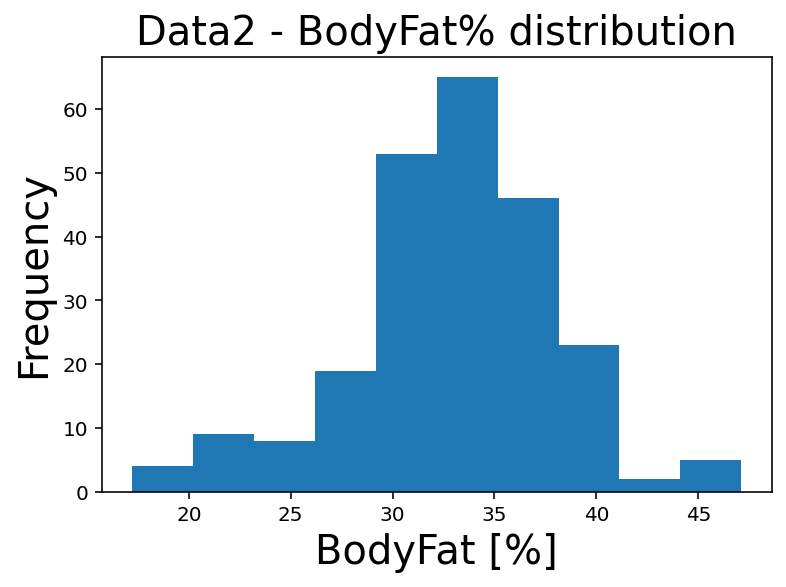

In [58]:
#the distribution of reponse variable: normal distribution 
plt.hist(male["BodyFat"])
title('Data2 - BodyFat% distribution', fontsize=20);
xlabel('BodyFat [%]', fontsize=20)
ylabel('Frequency', fontsize=20);

In [59]:
## MM is extreme highly correlated to FFM, FM is extreme highly correlated to FM.Kg
## MM，BMR，Bone mass
# Fat mass,BMI,bone mass,muscal mass,bmR，age
male_corr = male.corr()
male_corr[male_corr>0.7]

,Age,Height.cm,W.Kg,BMI,FatMass.Kg,FM,FFM.Kg,BMR.Kcal,BoneMass.Kg,MuscleMass.Kg,MM.Trunk.Kg,FFM.Trunk.Kg,FM.Trunk.Kg,FM.Trunk,MM.LA.Kg,FFM.LA.Kg,FM.LA.Kg,FM.LA,MM.RA.Kg,FFM.RA.Kg,FM.RA.Kg,FM.RA,MM.LL.Kg,FFM.LL.Kg,FM.RL.Kg,FM.LL,MM.RL.Kg,FFM.RL.Kg,FM.RL.Kg_A,FM.RL,BodyFat
Age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Height.cm,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W.Kg,NaN,NaN,1.000000,0.843132,0.917515,0.809862,0.814943,NaN,0.808874,0.814420,NaN,NaN,0.865648,0.755580,0.818699,0.820663,0.788817,NaN,0.736477,0.741094,0.815964,NaN,0.792634,0.796913,0.915725,0.733373,0.792635,0.799045,0.915300,0.734169,0.809314
BMI,NaN,NaN,0.843132,1.000000,0.847636,0.808472,NaN,NaN,NaN,NaN,NaN,NaN,0.718050,NaN,NaN,NaN,0.860165,0.766506,NaN,NaN,0.872693,0.769735,NaN,NaN,0.914483,0.811221,NaN,NaN,0.918937,0.824049,0.808152
FatMass.Kg,NaN,NaN,0.917515,0.847636,1.000000,0.966733,NaN,NaN,NaN,NaN,NaN,NaN,0.966017,0.928581,NaN,NaN,0.914900,0.800907,NaN,NaN,0.925409,0.814249,NaN,NaN,0.948007,0.817877,NaN,NaN,0.947644,0.823344,0.966516
FM,NaN,NaN,0.809862,0.808472,0.966733,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.936732,0.952757,NaN,NaN,0.901375,0.865069,NaN,NaN,0.902553,0.871496,NaN,NaN,0.907488,0.850924,NaN,NaN,0.907315,0.861011,0.999980
FFM.Kg,NaN,NaN,0.814943,NaN,NaN,NaN,1.000000,NaN,0.980797,0.999952,0.934408,0.936312,NaN,NaN,0.934645,0.938677,NaN,NaN,0.906077,0.911233,NaN,NaN,0.809262,0.824521,NaN,NaN,0.813326,0.829748,NaN,NaN,NaN
BMR.Kcal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.788728,0.710125,NaN,NaN,0.763822,0.702736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BoneMass.Kg,NaN,NaN,0.808874,NaN,NaN,NaN,0.980797,NaN,1.000000,0.978829,0.898901,0.904787,NaN,NaN,0.912932,0.917640,NaN,NaN,0.880825,0.886769,NaN,NaN,0.817567,0.829921,NaN,NaN,0.822719,0.836783,NaN,NaN,NaN
MuscleMass.Kg,NaN,NaN,0.814420,NaN,NaN,NaN,0.999952,NaN,0.978829,1.000000,0.935250,0.936951,NaN,NaN,0.934789,0.938783,NaN,NaN,0.906429,0.911541,NaN,NaN,0.808018,0.823409,NaN,NaN,0.812023,0.828548,NaN,NaN,NaN


In [60]:
# divide train and test dataset
train_index = split(male)[0]
test_index = split(male)[1]
data2_train = male.iloc[train_index]
data2_test = male.iloc[test_index]

# divide X and Y
# data1_train_x, data1_train_y = datasets.load
data2_train_y = data2_train.iloc[:, -1]
data2_train_x = data2_train.iloc[:, 0:-1]
data2_test_y = data2_test.iloc[:, -1]
data2_test_x = data2_test.iloc[:, 0:-1]
# data2_train_x

In [61]:
data2_train_x

,Age,Height.cm,W.Kg,BMI,FatMass.Kg,FM,FFM.Kg,BMR.Kcal,BoneMass.Kg,MuscleMass.Kg,MM.Trunk.Kg,FFM.Trunk.Kg,FM.Trunk.Kg,FM.Trunk,MM.LA.Kg,FFM.LA.Kg,FM.LA.Kg,FM.LA,MM.RA.Kg,FFM.RA.Kg,FM.RA.Kg,FM.RA,MM.LL.Kg,FFM.LL.Kg,FM.RL.Kg,FM.LL,MM.RL.Kg,FFM.RL.Kg,FM.RL.Kg_A,FM.RL
34,19.639825,162.9,64.8,25.8,23.8,36.7,41.0,1271.0,2.1,38.9,22.2,23.3,12.0,34.0,1.8,1.9,1.3,40.6,1.8,1.9,1.2,39.5,6.5,6.9,4.6,40.2,6.6,7.0,4.7,40.3
185,41.387173,177.1,59.3,25.0,18.3,30.9,41.0,1242.0,2.1,38.9,22.7,23.8,8.0,25.2,1.8,1.9,1.0,35.0,1.8,1.9,1.0,34.8,6.3,6.7,4.1,37.9,6.3,6.7,4.2,38.4
21,19.486502,162.9,62.3,25.4,21.5,34.5,40.8,1258.0,2.1,38.7,22.5,23.6,10.1,30.0,1.8,1.9,1.2,38.1,1.8,1.9,1.2,38.1,6.3,6.7,4.4,39.9,6.3,6.7,4.6,40.9
144,38.790904,181.4,67.4,27.2,25.4,37.7,42.0,1299.0,2.1,39.9,22.6,23.7,12.6,34.7,1.9,2.0,1.5,42.2,1.8,1.9,1.4,42.0,6.7,7.1,4.9,40.8,6.9,7.3,5.0,40.5
18,19.440043,162.9,59.5,23.1,18.5,31.1,41.0,1250.0,2.1,38.9,22.0,23.1,9.2,28.5,1.8,1.9,1.0,35.4,1.7,1.8,1.0,35.1,6.6,7.0,3.6,34.2,6.8,7.2,3.7,34.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,19.932654,162.9,56.3,23.0,14.9,26.5,41.4,1250.0,2.1,39.3,22.9,24.0,6.1,20.3,1.8,1.9,0.8,29.2,1.9,2.0,0.8,27.9,6.3,6.7,3.6,34.7,6.4,6.8,3.6,34.5
38,19.678106,162.9,59.6,24.5,18.2,30.5,41.4,1244.0,2.1,39.3,22.3,23.4,8.5,26.6,1.8,1.9,1.0,34.9,1.8,1.9,1.0,34.7,6.7,7.1,3.8,34.8,6.7,7.1,3.9,35.4
142,38.750651,181.4,64.3,24.1,22.1,34.4,42.2,1284.0,2.2,40.0,23.0,24.2,11.1,31.4,1.9,2.0,1.2,36.9,1.8,1.9,1.1,37.6,6.7,7.1,4.3,37.8,6.6,7.0,4.4,38.7
31,19.601480,162.9,63.9,24.7,22.1,34.6,41.8,1251.0,2.1,39.7,22.9,24.0,11.1,31.6,2.0,2.1,1.0,32.9,2.1,2.2,1.0,31.5,6.3,6.7,4.5,40.1,6.4,6.8,4.5,39.7


## Model 6: model using backward stepwise selection of dataset 2

In [63]:
x_columns=["Age","W.Kg","BMI","BMR.Kcal","MM.Trunk.Kg","FM.Trunk.Kg","FM.RL.Kg","MM.RL.Kg","FM.RA.Kg","MM.RA.Kg","FM.LA.Kg","MM.LA.Kg","MM.LL.Kg"]
y = data2_train_y
def get_stats():
    x=data2_train_x[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
    return results.params
# get_stats()
x_columns.remove("MM.LA.Kg")
# get_stats()
x_columns.remove("MM.RL.Kg")
# get_stats()
x_columns.remove("MM.RA.Kg")
backwards_model_6_params = get_stats()

                                 OLS Regression Results                                
Dep. Variable:                BodyFat   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.747e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):                   2.58e-259
Time:                        23:37:23   Log-Likelihood:                         -276.32
No. Observations:                 187   AIC:                                      572.6
Df Residuals:                     177   BIC:                                      605.0
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

 **backward stepwise selection result model of dataset 2**
 

\begin{align*}
    F_{i} &= 0.0263*Age_{i} -3.7485*Weight{i} + 0.6497*BMI_{i} + 0.0136*BMR_{i}  + 3.6612*MMTrunk_{i} + 5.1257*FMTrunk_{i} + 10.8050*FMRL_{i} + 2.9059*FMRA_{i} - 4.6893*FMLA_{i} + 8.4030*MMLL_{i}\\
  \end{align*}

In [64]:
model_6_beta_values = backwards_model_6_params
model_6_data_var_names = ["Age","W.Kg","BMI","BMR.Kcal","MM.Trunk.Kg","FM.Trunk.Kg","FM.RL.Kg","FM.RA.Kg","FM.LA.Kg","MM.LL.Kg"]

pred_y = zeros(data2_test_x.shape[0])
for i in range(len(model_6_data_var_names)):
    pred_y += model_6_beta_values[i]*data2_test_x[model_6_data_var_names[i]]
model_6_pred_y = pred_y.rename("BodyFat_pred")

In [65]:
model_6_adj_r_sq = get_adjusted_r_squared(model_6_pred_y, data2_test_y, data2_test_y.size, len(model_6_data_var_names))
print("Model 6 adjusted R square: ", model_6_adj_r_sq)

Model 6 adjusted R square:  0.9610406057501175
